In [1]:
!pip install segmentation-models-pytorch ttach

     |████████████████████████████████| 42 kB 789 kB/s eta 0:00:011
     |████████████████████████████████| 58 kB 3.3 MB/s eta 0:00:011
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=c711454d5cfc0c6161c51fe66f6ceb390ea7b2d2b2742539f2ea1988762ab22b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=0aa85b1b7e5e35c229875bd989ba1c649d12c2413265d8c2e034276e4313c3f0
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built pretrainedmodels efficientnet-pytorch


In [2]:
!pip install --pre torch==1.7.0.dev20200701+cu101 torchvision==0.8.0.dev20200701+cu101 -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
     |████████████████████████████████| 844.4 MB 8.3 kB/s  eta 0:00:01    |▋                               | 15.6 MB 44.8 MB/s eta 0:00:19     |▋                               | 16.9 MB 44.8 MB/s eta 0:00:19     |▊                               | 18.2 MB 44.8 MB/s eta 0:00:19     |▊                               | 20.2 MB 44.8 MB/s eta 0:00:19 MB 44.8 MB/s eta 0:00:19     |█▍                              | 37.5 MB 28.2 MB/s eta 0:00:29     |███                             | 79.2 MB 46.5 MB/s eta 0:00:17     |████████████████████▎           | 536.3 MB 55.1 MB/s eta 0:00:06:00:06     |██████████████████████▏         | 583.5 MB 46.6 MB/s eta 0:00:06     |██████████████████████▎         | 587.3 MB 46.6 MB/s eta 0:00:06     |██████████████████████▌         | 593.7 MB 46.6 MB/s eta 0:00:06     |██████████████████████▊         | 598.5 MB 46.6 MB/s eta 0:00:06MB/s eta 0:00:04     |██████████████████████████▎   

In [32]:
import wandb
wandb.login(key='44b74d6614becfad4329893ea0144da65336bdbd')

is_fp16_used = True

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
from typing import Callable, List, Tuple

import os
import torch
import catalyst

from catalyst.dl import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


torch: 1.7.0.dev20200701+cu101, catalyst: 20.07


In [5]:
from pathlib import Path

ROOT = Path("../input/semantic-drone-dataset/semantic_drone_dataset/")

train_image_path = ROOT / "original_images"
train_mask_path = ROOT / "label_images_semantic"

In [6]:
ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
len(ALL_IMAGES)

400

In [7]:
ALL_MASKS = sorted(train_mask_path.glob("*.png"))
len(ALL_MASKS)

400

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np
from catalyst import utils


def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(14, 18))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = utils.imread(image_path)
    mask = utils.imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

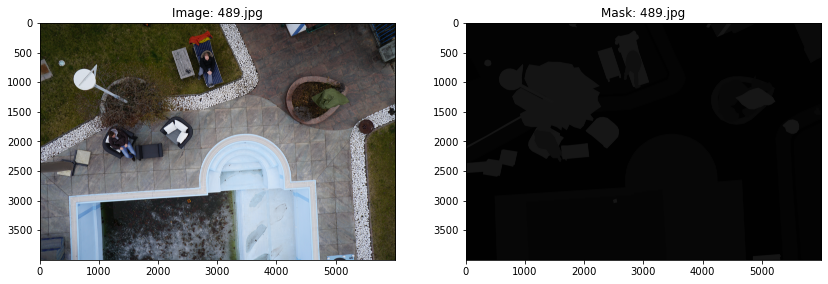

In [9]:
show_random(ALL_IMAGES, ALL_MASKS)

In [71]:
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        
        result = {"image": image}
        
        if self.masks is not None:
            mask = utils.imread(self.masks[idx])
            result["mask"] = mask
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["filename"] = image_path.name

        return result

In [11]:
import albumentations as albu
from albumentations.pytorch import ToTensor


def pre_transforms():
    return [albu.Resize(576, 864, p=1),
           albu.PadIfNeeded(min_height=864, min_width=864, always_apply=True, border_mode=0)]


def hard_transforms():
    result = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.OneOf([
            albu.RandomBrightnessContrast(
              brightness_limit=0.3, contrast_limit=0.3, p=1),
            albu.CLAHE(p=1),
        ],
        p=1,
        ),
        albu.HueSaturationValue(p=0.3)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]
  
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [12]:
train_transforms = compose([
    pre_transforms(), 
    hard_transforms(),
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([hard_transforms()])

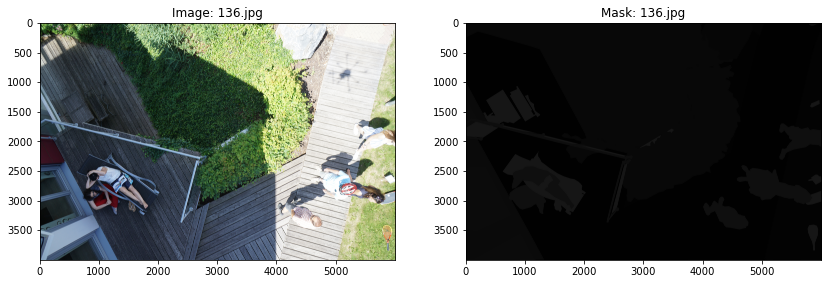

In [39]:
show(index=89, images=ALL_IMAGES, masks=ALL_MASKS)

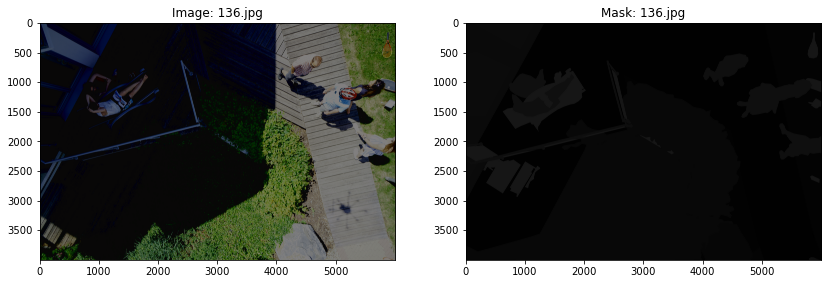

In [13]:
show(index=89, images=ALL_IMAGES, masks=ALL_MASKS, transforms=show_transforms)

In [14]:
from collections import OrderedDict
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.25,
    batch_size: int = 2,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [15]:
if is_fp16_used:
    batch_size = 4
else:
    batch_size = 2

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=42,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms
)

batch_size: 4


In [56]:
import segmentation_models_pytorch as smp

# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
model = smp.FPN(encoder_name="resnext50_32x4d", classes=20)

In [51]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

In [52]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)

In [53]:
from catalyst.dl import SupervisedRunner

num_epochs = 3
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")

if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda
FP16 params: {'opt_level': 'O1'}


In [46]:
from catalyst import dl

class CustomRunner(dl.Runner):
    
    def predict_batch(self, batch):
        # model inference step
        return self.model(batch[0].to(self.device).view(batch[0].size(0), -1))
    
    def _handle_batch(self, batch):
        x, y = batch
        x = x.view(len(x), -1)
        logits = self.model(x)
        loss = self.state.criterion(logits, y)
        self.state.batch_metrics["loss"] = loss
        
        if self.state.is_train_loader:
            loss.backward()
            self.state.optimizer.step()
            self.state.optimizer.zero_grad() 

In [47]:
runner = CustomRunner()

In [54]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback, WandbLogger

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    
    WandbLogger(project='X', name='1')
]


In [55]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    verbose=True
)

wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade





1/3 * Epoch (train):   0% 0/150 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (3) must match the size of tensor b (864) at non-singleton dimension 4

In [57]:
!pip install pytorch-lightning

     |████████████████████████████████| 313 kB 9.1 MB/s eta 0:00:01


In [58]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.nn import functional as F
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.metrics.functional.classification import accuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateLogger
from pytorch_lightning.loggers import WandbLogger
from torch.optim import Adam
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

In [66]:
class EffNet(LightningModule):

    def __init__(self, 
                #num_target_classes = 196,
                #backbone: str = 'efficientnet-b5',
                batch_size: int = 4,
                lr: float = 5e-4,
                wd: float = 0,
                num_workers: int = 4,
                factor: float = 0.5,
                **kwargs):
        super().__init__()
        #self.num_target_classes = num_target_classes
        #self.backbone= backbone
        self.batch_size = batch_size
        self.lr = lr
        self.wd = wd
        self.num_workers = num_workers
        self.factor = factor
        self.save_hyperparameters()

        self.__build_model()
        
    def __build_model(self):
        self.net = smp.FPN(encoder_name="resnext50_32x4d", classes=20)
        #in_features = self.net._fc.in_features

        #_fc_layers = [nn.Linear(in_features, self.num_target_classes)]
        #self.net._fc = nn.Sequential(*_fc_layers)

    def forward(self, x):

        return self.net.forward(x)
    
    def training_step(self, batch, batch_idx):

        x, y = batch
        y_logits = self.forward(x)

        train_loss = F.cross_entropy(y_logits, y)
        #acc, acc2 = self.__accuracy(y_logits, y, topk=(1,2))

        return {'train_loss': train_loss}
    
    def validation_step(self, batch, batch_idx):

        x, y = batch
        y_logits = self.forward(x)

        val_loss = F.cross_entropy(y_logits, y)
        #acc, acc2 = self.__accuracy(y_logits, y, topk=(1,2))

        return {'val_loss': val_loss}

    def validation_epoch_end(self, outputs):
        """Compute and log validation loss and accuracy at the epoch level."""

        val_loss_mean = torch.stack([output['val_loss']
                                     for output in outputs]).mean()
        #avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        #avg_acc2 = torch.stack([x['top2_acc'] for x in outputs]).mean()
        
        tensorboard_logs = {'val_loss': val_loss_mean}#, 'val_acc': avg_acc,
                            #'top2_acc': avg_acc2}
        return {'val_loss': val_loss_mean,  'log': tensorboard_logs}

    @classmethod
    def __accuracy(cls, output, target, topk=(1,)):
        """Computes the accuracy over the k top predictions for the specified values of k"""
        with torch.no_grad():
            maxk = max(topk)
            batch_size = target.size(0)

            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
                res.append(correct_k.mul_(1.0 / batch_size))
            return res

    def configure_optimizers(self):

        optimizer = Adam(self.parameters(),
            lr=self.lr, weight_decay=self.wd)
        lr_scheduler = {'scheduler': ReduceLROnPlateau(optimizer, factor=self.factor, 
            patience=2, mode='max')
            ,'name': 'learning_rate',
            'monitor': 'val_acc'}
        return [optimizer], [lr_scheduler]
    
    def setup(self, stage: str):
        indices = np.arange(400)

    # Let's divide the data set into train and valid parts.
        train_indices, valid_indices = train_test_split(
          indices, test_size=0.25, random_state=42, shuffle=True
            )

        np_images = np.array(ALL_IMAGES)
        np_masks = np.array(ALL_MASKS)
        
        data_dir = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data'

        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        train_transforms = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean, std, inplace=True)
        ])
        #train = ImageFolder(data_dir+'/train', train_transforms)

        # transform val
        val_transforms = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std, inplace=True)
        ])
        #val = ImageFolder(data_dir+'/test', val_transforms)
        #valid, _ = random_split(val, [len(val), 0])
        
            # Creates our train dataset
        train_dataset = SegmentationDataset(
          images = np_images[train_indices].tolist(),
          masks = np_masks[train_indices].tolist(),
          transforms = train_transforms
            )

    # Creates our valid dataset
        valid_dataset = SegmentationDataset(
          images = np_images[valid_indices].tolist(),
          masks = np_masks[valid_indices].tolist(),
          transforms = val_transforms
        )

        # assign to use in dataloaders
        self.train_dataset = train_dataset
        self.val_dataset = valid_dataset

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset,
                            batch_size=self.batch_size,
                            num_workers=self.num_workers,
                            shuffle=True,
                            pin_memory=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset,
                            batch_size=self.batch_size,
                            num_workers=self.num_workers,
                            shuffle=False,
                            pin_memory=True)

In [67]:
def main():

    seed_everything(42)
    model = EffNet()
    
    wandb_logger = WandbLogger(name='1', project="X")
    # optional: log model topology
    #wandb_logger.watch(model.net)

    checkpoint_cb = ModelCheckpoint(filepath = './cars-{epoch:02d}-{val_acc:.4f}',monitor='val_acc', mode='max')
    early = EarlyStopping(patience=5, monitor='val_acc', mode='max')

    trainer = Trainer(
        gpus=1,
        logger=wandb_logger,
        max_epochs=30,
        progress_bar_refresh_rate=5,
        deterministic=True,
        precision=16,
        checkpoint_callback=checkpoint_cb,
        early_stop_callback=early,
        callbacks=[LearningRateLogger()],
    )

    trainer.fit(model)
    
    wandb.save(checkpoint_cb.best_model_path)

#def get_args() -> Namespace:
#    parser = EffNet.add_model_specific_args()
#    return parser.parse_args()

if __name__ == '__main__':
    main()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

  | Name | Type | Params
------------------------------
0 | net  | FPN  | 25 M  


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-65-1dbbc2b2b497>", line 29, in __getitem__
    result = self.transforms(**result)
TypeError: __call__() got an unexpected keyword argument 'image'


In [70]:
model.classification_head